## 使用 pdfplumber 解析 PDF 文件

### 项目简介

[pdfplumber](https://github.com/jsvine/pdfplumber) 项目(基于pdfminer.six开发)，支持解析PDF文件，获取每个文本字符、矩形和线条的详细信息。此外还支持表格提取和可视化调试。

对于机器生成的PDF而言效果最佳，不适用于扫描得到的PDF。

支持：Python 3.8~3.11

![](images/pdfplumber.png)


本 Notebook 主要内容如下：

- 加载PDF文件
- 提取单页文本
- 提取单页表格
- 可视化调试页面
- 提取页面图像

### 加载PDF文件

要开始处理PDF，请调用`pdfplumber.open(x)`方法，其中`x`可以是：

- PDF 文件路径
- 作为字节加载的文件对象
- 作为字节加载的类似文件的对象

open方法将返回一个`pdfplumber.PDF`类的实例。

##### 高级加载参数

要加载受密码保护的PDF，请传递`password`关键字参数，例如：`pdfplumber.open("file.pdf", password="test")`。

要设置布局分析参数到`pdfminer.six`的布局引擎中，请传递`laparams`关键字参数，例如：`pdfplumber.open("file.pdf", laparams={"line_overlap": 0.7})`。



### pdfplumber.PDF 类(Top-level)

`pdfplumber.PDF`类表示一个独立的PDF文件，两个主要成员变量：

| 属性 | 描述 |
|----------|-------------|
|`.metadata`| 一个由PDF的 `Info` 尾部信息中的元数据键/值对组成的字典。通常包括 "CreationDate," "ModDate," "Producer," 等等。|
|`.pages`| 包含每个已加载页面的 `pdfplumber.Page` 实例的列表。|

一个主要成员方法：

| 方法 | 描述 |
|--------|-------------|
|`.close()`| 默认情况下，`Page` 对象会缓存其布局和对象信息，以避免重新处理。然而，在解析大型PDF时，这些缓存的属性可能需要大量内存。你可以使用此方法来清除缓存并释放内存。（在 `<= 0.5.25` 版本中，使用 `.flush_cache()`。）|

In [1]:
import pdfplumber

pdf = pdfplumber.open("hsbc_pdf-1.pdf")

In [2]:
pdf.metadata

{'Title': 'ACS Service Value Review',
 'Author': "Elroy D'Souza",
 'CreationDate': "D:20230801130223+08'00'",
 'ModDate': "D:20230801130223+08'00'",
 'Producer': 'Microsoft® PowerPoint® for Microsoft 365',
 'Creator': 'Microsoft® PowerPoint® for Microsoft 365'}

In [3]:
pdf.pages

[<Page:1>]

### pdfplumber.Page 类

`pdfplumber.Page` 类是 `pdfplumber` 的核心，表示PDF文件中一页单独的内容。

当我们使用 `pdfplumber` 时，大部分操作都会围绕这个类展开。

主要成员变量如下：

| 属性 | 描述 |
|----------|-------------|
|`.page_number`| 顺序页码，从第一页开始为 `1`，第二页为 `2`，以此类推。|
|`.width`| 页面的宽度。|
|`.height`| 页面的高度。|
|`.objects` / `.chars` / `.lines` / `.rects` / `.curves` / `.images`| 这些属性都是列表，每个列表包含页面上嵌入的每个此类对象的一个字典。


In [4]:
pdf = pdfplumber.open("hsbc_pdf-1.pdf")

In [5]:
pages = pdf.pages
print(pages)

[<Page:1>]


In [6]:
pages[0].page_number

1

In [7]:
print(pages[0].width, pages[0].height)

960 540


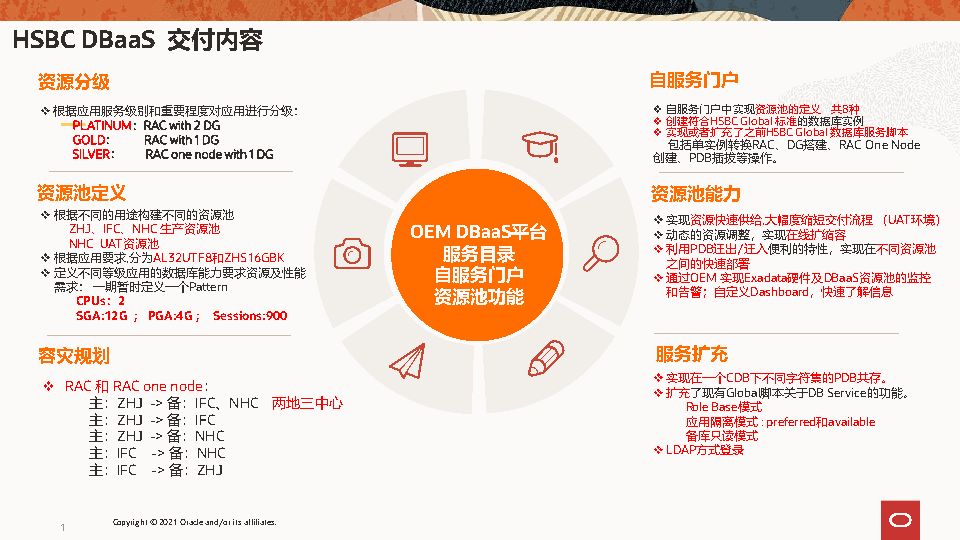

In [8]:
# 可视化第1页
pages[0].to_image()

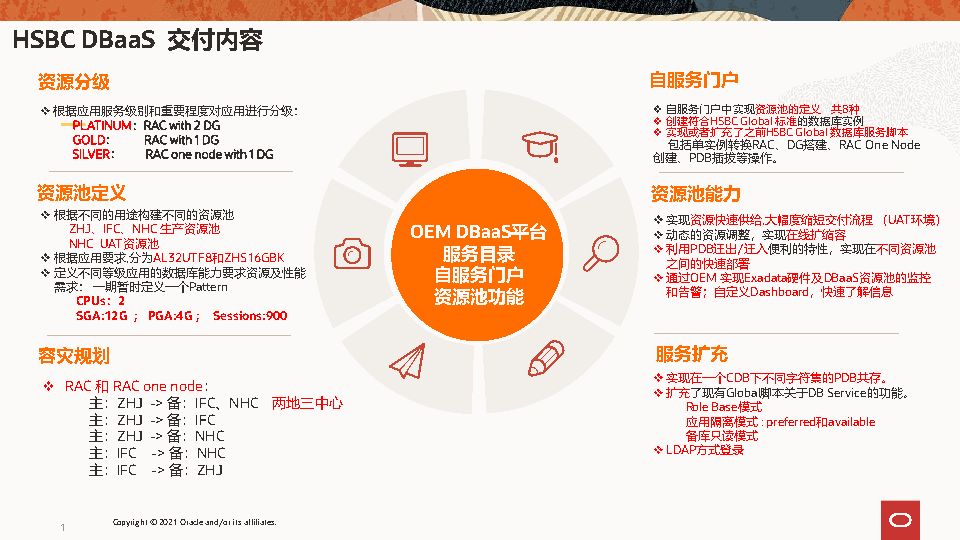

In [10]:
# 可视化第2页（尝试调整分辨率和抗锯齿）
pages[0].to_image()

### 提取单页文本


`pdfplumber`库支持从任何给定的页面(`pdfplumber.Page`)中提取文本（包括裁剪和派生页面）。

在提取文本的基础功能外，同时支持保留文本布局，识别单词和搜索页面中的文本

#### 文本提取方法

`pdfplumber.Page` 对象可以调用以下方法：

| 方法 | 描述 |
|--------|-------------|
|`.extract_text(x_tolerance=3, y_tolerance=3, layout=False, x_density=7.25, y_density=13, **kwargs)`| 将页面的所有字符对象汇集成一个单一的字符串。<ul><li><p>当 `layout=False` 时：在一个字符的 `x1` 和下一个字符的 `x0` 之间的差异大于 `x_tolerance` 时添加空格。在一个字符的 `doctop` 和下一个字符的 `doctop` 之间的差异大于 `y_tolerance` 时添加换行符。</p></li><li><p>当 `layout=True`（*实验性功能*）时：尝试模仿页面上文本的结构布局，使用 `x_density` 和 `y_density` 来确定每个"点"（PDF的度量单位）的最小字符/换行符数量。所有剩余的 `**kwargs` 都传递给 `.extract_words(...)`（见下文），这是计算布局的第一步。</p></li></ul>|
|`.extract_text_simple(x_tolerance=3, y_tolerance=3)`| `.extract_text(...)` 的稍快但不太灵活的版本，使用更简单的逻辑。|
|`.extract_words(x_tolerance=3, y_tolerance=3, keep_blank_chars=False, use_text_flow=False, horizontal_ltr=True, vertical_ttb=True, extra_attrs=[], split_at_punctuation=False, expand_ligatures=True)`| 返回所有看起来像单词的东西及其边界框的列表。单词被认为是字符序列，其中（对于"直立"字符）一个字符的 `x1` 和下一个字符的 `x0` 之间的差异小于或等于 `x_tolerance` *并且* 一个字符的 `doctop` 和下一个字符的 `doctop` 之间的差异小于或等于 `y_tolerance`。对于非直立字符，采取类似的方法，但是测量它们之间的垂直距离，而不是水平距离。参数 `horizontal_ltr` 和 `vertical_ttb` 表示是否应从左到右阅读单词（对于水平单词）/从上到下（对于垂直单词）。将 `keep_blank_chars` 更改为 `True` 将意味着空白字符被视为单词的一部分，而不是单词之间的空格。将 `use_text_flow` 更改为 `True` 将使用PDF的底层字符流作为排序和划分单词的指南，而不是预先按x/y位置排序字符。（这模仿了在PDF中拖动光标突出显示文本的方式；就像那样，顺序并不总是看起来逻辑。）传递 `extra_attrs` 列表（例如，`["fontname", "size"]` 将限制每个单词的字符具有完全相同的值，对于这些[属性](#char-properties)，并且结果的单词dicts将指示这些属性。将 `split_at_punctuation` 设置为 `True` 将在 `string.punctuation` 指定的标点处强制分割标记；或者你可以通过传递一个字符串来指定分隔标点的列表，例如，<code>split_at_punctuation='!"&\'()*+,.:;<=>?@[\]^\`\{\|\}~'</code>。除非你设置 `expand_ligatures=False`，否则将展开诸如 `ﬁ` 之类的连字成其组成字母（例如，`fi`）。|
|`.extract_text_lines(layout=False, strip=True, return_chars=True, **kwargs)`|*实验性功能*，返回代表页面上文本行的字典列表。`strip` 参数类似于Python的 `str.strip()` 方法，并返回没有周围空白的 `text` 属性。（只有当 `layout = True` 时才相关。）将 `return_chars` 设置为 `False` 将排除从返回的文本行dicts中添加单个字符对象。剩余的 `**kwargs` 是你将传递给 `.extract_text(layout=True, ...)` 的参数。|
|`.search(pattern, regex=True, case=True, main_group=0, return_groups=True, return_chars=True, layout=False, **kwargs)`|*实验性功能*，允许你搜索页面的文本，返回匹配查询的所有实例的列表。对于每个实例，响应字典对象包含匹配的文本、任何正则表达式组匹配、边界框坐标和字符对象本身。`pattern` 可以是编译的正则表达式、未编译的正则表达式或非正则字符串。如果 `regex` 是 `False`，则将模式视为非正则字符串。如果 `case` 是 `False`，则以不区分大小写的方式执行搜索。设置 `main_group` 将结果限制为 `pattern` 中的特定正则组（`0` 的默认值表示整个匹配）。将 `return_groups` 和/或 `return_chars` 设置为 `False` 将排除添加匹配的正则组和/或字符的列表（作为 `"groups"` 和 `"chars"` 添加到返回的dicts）。`layout` 参数的操作方式与 `.extract_text(...)` 相同。剩余的 `**kwargs` 是你将传递给 `.extract_text(layout=True, ...)` 的参数。 __注意__：零宽度和全空白匹配被丢弃，因为它们（通常）在页面上没有明确的位置。 |
|`.dedupe_chars(tolerance=1)`| 返回页面的版本，其中删除了重复的字符 — 那些与其他字符共享相同的文本、字体名、大小和位置（在 `tolerance` x/y 内）的字符。（参见 [Issue #71](https://github.com/jsvine/pdfplumber/issues/71) 以理解动机。）|


In [11]:
# 获取单页文本
p1_text = pages[0].extract_text()

In [12]:
print(p1_text)

HSBC DBaaS 交付内容
资源分级 自服务门户
❖根据应用服务级别和重要程度对应用进行分级： ❖ 自服务门户中实现资源池的定义 共8种
❖ 创建符合HSBC Global 标准的数据库实例
PLATINUM：RAC with 2 DG
❖ 实现或者扩充了之前HSBC Global 数据库服务脚本
GOLD： RAC with 1 DG
包括单实例转换RAC、DG搭建、RAC One Node
SILVER： RAConenodewith1DG
创建、PDB插拔等操作。
资源池定义 资源池能力
❖根据不同的用途构建不同的资源池
❖实现资源快速供给,大幅度缩短交付流程（UAT环境）
ZHJ、IFC、NHC 生产资源池 OEM DBaaS平台
❖动态的资源调整，实现在线扩缩容
NHC UAT资源池
服务目录 ❖利用PDB迁出/迁入便利的特性，实现在不同资源池
❖根据应用要求,分为AL32UTF8和ZHS16GBK
之间的快速部署
❖定义不同等级应用的数据库能力要求资源及性能 自服务门户
❖通过OEM 实现Exadata硬件及DBaaS资源池的监控
需求：一期暂时定义一个Pattern
资源池功能 和告警；自定义Dashboard，快速了解信息
CPUs：2
SGA:12G ；PGA:4G ； Sessions:900
容灾规划 服务扩充
❖实现在一个CDB下不同字符集的PDB共存。
❖ RAC 和 RAC one node：
❖扩充了现有Global脚本关于DB Service的功能。
主：ZHJ -> 备：IFC、NHC 两地三中心
Role Base模式
主：ZHJ -> 备：IFC 应用隔离模式: preferred和available
主：ZHJ -> 备：NHC 备库只读模式
主：IFC -> 备：NHC ❖LDAP方式登录
主：IFC -> 备：ZHJ
Copyright © 2021 Oracle and/or its affiliates.
1


In [30]:
# 获取单页文本（保留布局）
p1_text = pages[0].extract_text(layout=True)

In [33]:
print(p1_text)
# if p1_text:
#     # Remove empty lines and leading/trailing whitespaces
#     raw_text_lines = p1_text.splitlines()
#     cleaned_raw_text_lines = [line.strip() for line in raw_text_lines if line.strip()]
#     cleaned_raw_text = "\n".join(cleaned_raw_text_lines)
#     print(cleaned_raw_text)

                                                                                                                                    
                                                                                                                                    
  HSBC     DBaaS       交付内容                                                                                                         
                                                                                                                                    
                                                                                                                                    
                                                                                                                                    
     资源分级                                                                                 自服务门户                                     
                                                                     

**注意：表格也被文本解析出来了**

### 提取单页表格


`pdfplumber` 对表格提取的方法大量借鉴了 [Anssi Nurminen 的硕士论文](http://dspace.cc.tut.fi/dpub/bitstream/handle/123456789/21520/Nurminen.pdf?sequence=3)，并受到 [Tabula](https://github.com/tabulapdf/tabula-extractor/issues/16) 的启发。

它的工作原理如下：

1. 对于任何给定的PDF页面，找到那些（a）明确定义的线条和/或（b）由页面上单词的对齐方式暗示的线条。
2. 合并重叠的，或几乎重叠的，线条。
3. 找到所有这些线条的交点。
4. 找到使用这些交点作为顶点的最精细的矩形集合（即，单元格）。
5. 将连续的单元格分组成表格。

#### 表格提取方法

`pdfplumber.Page` 对象可以调用以下方法：

| 方法 | 描述 |
|--------|-------------|
|`.find_tables(table_settings={})`|返回一个 `Table` 对象的列表。`Table` 对象提供对 `.cells`，`.rows`，和 `.bbox` 属性的访问，以及 `.extract(x_tolerance=3, y_tolerance=3)` 方法。|
|`.find_table(table_settings={})`|类似于 `.find_tables(...)`，但返回页面上 *最大* 的表格，作为一个 `Table` 对象。如果多个表格的大小相同 —— 以单元格数量衡量 —— 此方法返回最接近页面顶部的表格。|
|`.extract_tables(table_settings={})`|返回从页面上找到的 *所有* 表格中提取的文本，表示为一个列表的列表的列表，结构为 `table -> row -> cell`。|
|`.extract_table(table_settings={})`|返回从页面上 *最大* 的表格中提取的文本（参见上面的 `.find_table(...)`），表示为一个列表的列表，结构为 `row -> cell`。|
|`.debug_tablefinder(table_settings={})`|返回 `TableFinder` 类的一个实例，可以访问 `.edges`，`.intersections`，`.cells`，和 `.tables` 属性。|

In [96]:
# 获取单页表格
p1_table = pages[0].extract_table()

In [97]:
p1_table

[['Fruit', 'Color', 'Price (USD)'],
 ['Apple', 'Red', '1.20'],
 ['Banana', 'Yellow', '0.50'],
 ['Orange', 'Orange', '0.80'],
 ['Strawberry', 'Red', '2.50'],
 ['Blueberry', 'Blue', '3.00'],
 ['Kiwi', 'Green', '1.00'],
 ['Mango', 'Orange', '1.50'],
 ['Grape', 'Purple', '2.00']]

In [98]:
# 获取单页所有表格
tables = pages[0].extract_tables()

In [99]:
len(tables)

1

In [100]:
tables

[[['Fruit', 'Color', 'Price (USD)'],
  ['Apple', 'Red', '1.20'],
  ['Banana', 'Yellow', '0.50'],
  ['Orange', 'Orange', '0.80'],
  ['Strawberry', 'Red', '2.50'],
  ['Blueberry', 'Blue', '3.00'],
  ['Kiwi', 'Green', '1.00'],
  ['Mango', 'Orange', '1.50'],
  ['Grape', 'Purple', '2.00']]]

In [ ]:
p1_debug_table = pages[0].debug_tablefinder()

In [88]:
type(p1_debug_table)

pdfplumber.table.TableFinder

In [91]:
p1_debug_table.tables

#### 使用 Pandas.DataFrame 来展示和存储表格

In [85]:
import pandas as pd

df = pd.DataFrame(p1_table[1:], columns=p1_table[0])

In [86]:
df

,Fruit,Color,Price (USD)
0,Apple,Red,1.20
1,Banana,Yellow,0.50
2,Orange,Orange,0.80
3,Strawberry,Red,2.50
4,Blueberry,Blue,3.00
5,Kiwi,Green,1.00
6,Mango,Orange,1.50
7,Grape,Purple,2.00


### 可视化调试页面

`pdfplumber` 可视化调试工具可以帮助我们理解PDF文件的内容和结构，以及从中提取出来的对象。


#### `PageImage` 类

`pdfplumber.Page` 对象可以使用`.to_image()`方法，将任何页面（包括裁剪后的页面）转换为`PageImage`对象。

`pdfplumber.Page.to_image()`方法主要参数：

- resolution：所需每英寸像素数。默认值：72。类型：整数。
- width：所需图像宽度（以像素为单位）。默认值：未设置，由分辨率确定。类型：整数。
- height：所需图像高度（以像素为单位）。默认值：未设置，由分辨率确定。类型：整数。
- antialias: 是否在创建图像时使用抗锯齿。将其设置为True可以创建具有较少锯齿的文本和图形，但文件大小会更大。默认值：False。类型：布尔值。

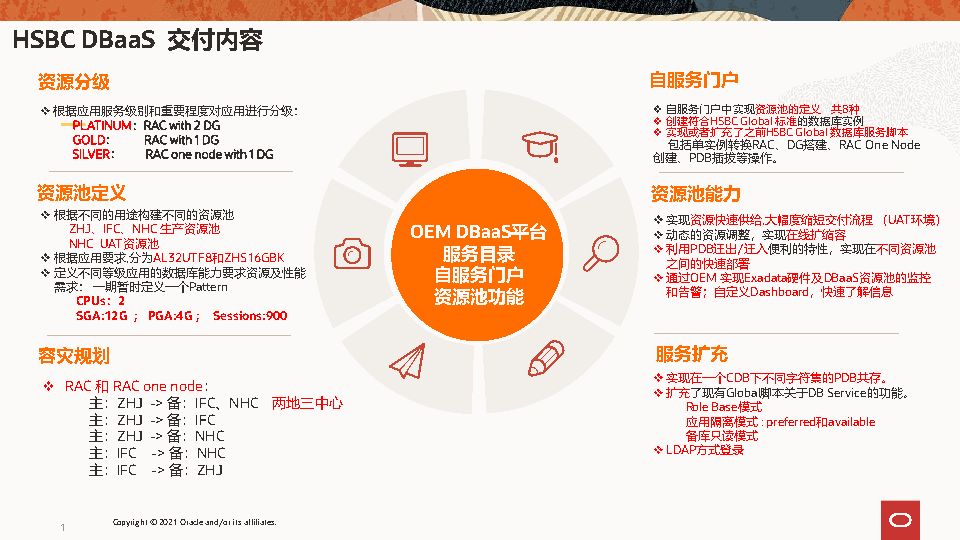

In [17]:
# 可视化第一页
pages[0].to_image()

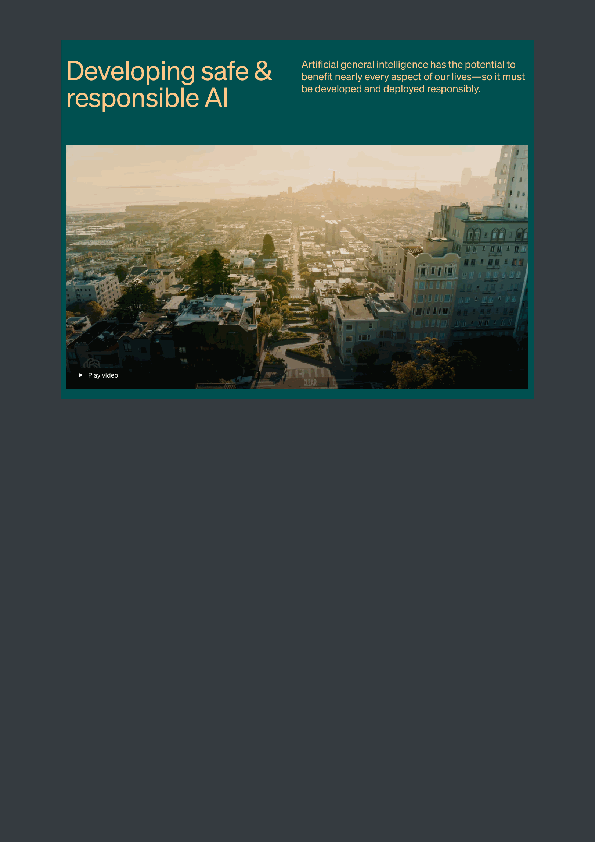

In [113]:
# 可视化第二页（尝试调整分辨率和抗锯齿）
pages[1].to_image()

### 提取页面图像

`pdfplumber.Page`  对象没有 extract_images 方法，所以不能直接从 PDF 页面中提取图像。

但是，可以通过页面操作来截取和获取图像，`pdfplumber.Page`类相关成员变量如下：


| 属性 | 描述 |
|----------|-------------|
|`.width`| 页面的宽度。|
|`.height`| 页面的高度。|
|`.objects` / `.chars` / `.lines` / `.rects` / `.curves` / `.images`| 这些属性都是列表，每个列表包含页面上嵌入的每个此类对象的一个字典。


相关成员方法：

| 方法 | 描述 |
|--------|-------------|
|`.crop(bounding_box, relative=False, strict=True)`| 返回裁剪到边界框的页面版本，边界框应表示为4元组，值为 `(x0, top, x1, bottom)`。裁剪的页面保留至少部分在边界框内的对象。如果对象只部分在框内，其尺寸将被切割以适应边界框。如果 `relative=True`，则边界框是从页面边界框的左上角偏移计算的，而不是绝对定位。（请参见 [Issue #245](https://github.com/jsvine/pdfplumber/issues/245) 以获取视觉示例和解释。）当 `strict=True`（默认值）时，裁剪的边界框必须完全在页面的边界框内。|
|`.within_bbox(bounding_box, relative=False, strict=True)`| 类似于 `.crop`，但只保留 *完全在* 边界框内的对象。|
|`.outside_bbox(bounding_box, relative=False, strict=True)`| 类似于 `.crop` 和 `.within_bbox`，但只保留 *完全在* 边界框外的对象。|
|`.filter(test_function)`| 返回只有 `test_function(obj)` 返回 `True` 的 `.objects` 的页面版本。|



In [18]:
# 从 PageImage 中获取页面图像分辨率
pages[0].images

[{'x0': 778.08,
  'y0': 365.04,
  'x1': 960.0,
  'y1': 498.96000000000004,
  'width': 181.91999999999996,
  'height': 133.92000000000002,
  'stream': <PDFStream(6): raw=24789, {'Type': /'XObject', 'Subtype': /'Image', 'Width': 412, 'Height': 303, 'ColorSpace': /'DeviceRGB', 'BitsPerComponent': 8, 'Interpolate': False, 'SMask': <PDFObjRef:7>, 'Filter': /'FlateDecode', 'Length': 24789}>,
  'srcsize': (412, 303),
  'imagemask': None,
  'bits': 8,
  'colorspace': [/'DeviceRGB'],
  'object_type': 'image',
  'page_number': 1,
  'top': 41.039999999999964,
  'bottom': 174.95999999999998,
  'doctop': 41.039999999999964},
 {'x0': 0.0,
  'y0': 519.96,
  'x1': 960.0,
  'y1': 540.0,
  'width': 960.0,
  'height': 20.039999999999964,
  'stream': <PDFStream(10): raw=17348, {'Type': /'XObject', 'Subtype': /'Image', 'Width': 1920, 'Height': 40, 'ColorSpace': /'DeviceRGB', 'BitsPerComponent': 8, 'Filter': /'DCTDecode', 'Interpolate': True, 'Length': 17348}>,
  'srcsize': (1920, 40),
  'imagemask': None,


In [24]:
img = pages[0].images[1]

In [25]:
bbox = (img["x0"], img["top"], img["x1"], img["bottom"])

In [26]:
cropped_page = pages[0].crop(bbox)

In [27]:
# 可视化裁剪后的第二页
cropped_page.to_image()

In [28]:
# 可视化裁剪后的第二页+抗锯齿
cropped_page.to_image(antialias=True)

In [159]:
im = cropped_page.to_image(antialias=True)
im.save("pdf_image_test.png")